# Saved States Analysis (Simple)

Visualizations for analyzing LLM intermediate activations.

In [ ]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load session
session_path = "saved_states/20251203_000329_france_no_attn_4" # update this path as needed
items = np.load(f"{session_path}/tensors.npz")
with open(f"{session_path}/config.json") as f:
    config = json.load(f)

# Extract data
print("The npz has keys:", items.files)
hidden_states = items['hidden_states'].squeeze(1) 
layer_names = items['layer_names']
num_layers, seq_len, dim = hidden_states.shape

print(f"Text: {config['text']}")
print(f"Model: {config['model_name']}")
print(f"Hidden states shape: {hidden_states.shape}")

The npz has keys: ['hidden_states', 'logits', 'layer_names', 'post_attention_states', 'attentions']
Text: The capital of France is
Model: meta-llama/Llama-3.2-1B
Hidden states shape: (33, 6, 2048)


In [28]:
def cosine_similarity(a, b):
    """Compute cosine similarity between two vectors."""
    dot = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    if norm_a == 0 or norm_b == 0:
        return 0.0
    return dot / (norm_a * norm_b)

token_labels = [f"T{i}" for i in range(seq_len)]
num_blocks = (num_layers - 1) // 2
block_labels = [f"L{i}" for i in range(num_blocks)]

## 1. Cosine Similarity Between Consecutive Layers

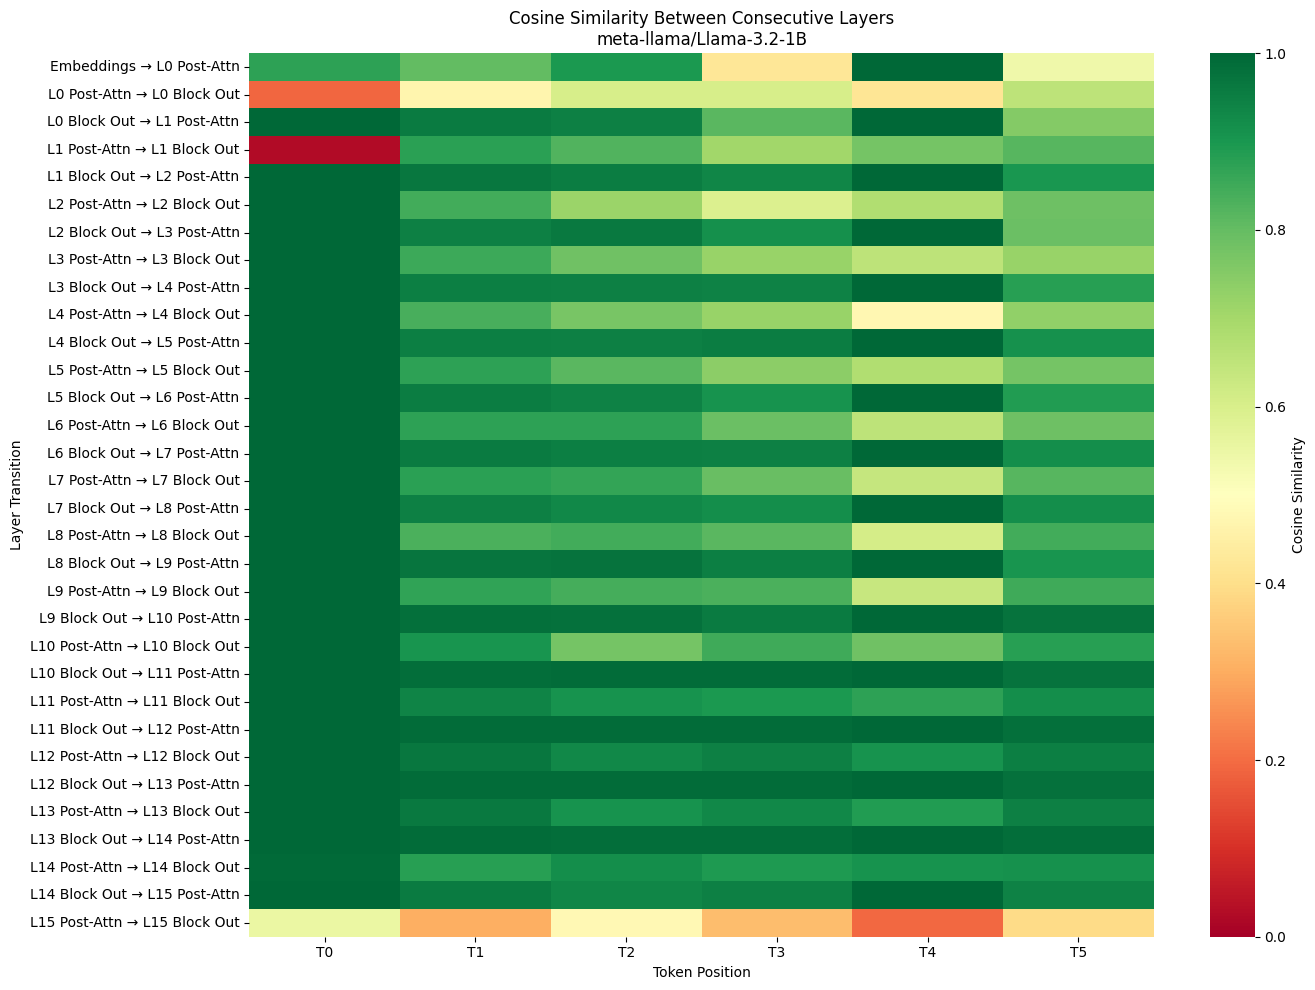

In [29]:
# Compute cosine similarity between consecutive layers for each token
cosine_sim_consecutive = np.zeros((num_layers - 1, seq_len))

for layer_idx in range(num_layers - 1):
    for token_idx in range(seq_len):
        cosine_sim_consecutive[layer_idx, token_idx] = cosine_similarity(
            hidden_states[layer_idx, token_idx],
            hidden_states[layer_idx + 1, token_idx]
        )

# Create labels for layer transitions
transition_labels = [f"{layer_names[i]} → {layer_names[i+1]}" for i in range(num_layers - 1)]

# Plot cosine similarity heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    cosine_sim_consecutive,
    xticklabels=token_labels,
    yticklabels=transition_labels,
    cmap='RdYlGn',
    vmin=0, vmax=1,
    cbar_kws={'label': 'Cosine Similarity'}
)
plt.title(f'Cosine Similarity Between Consecutive Layers\n{config["model_name"]}')
plt.xlabel('Token Position')
plt.ylabel('Layer Transition')
plt.tight_layout()
plt.show()

## 2. Activation Statistics per Layer

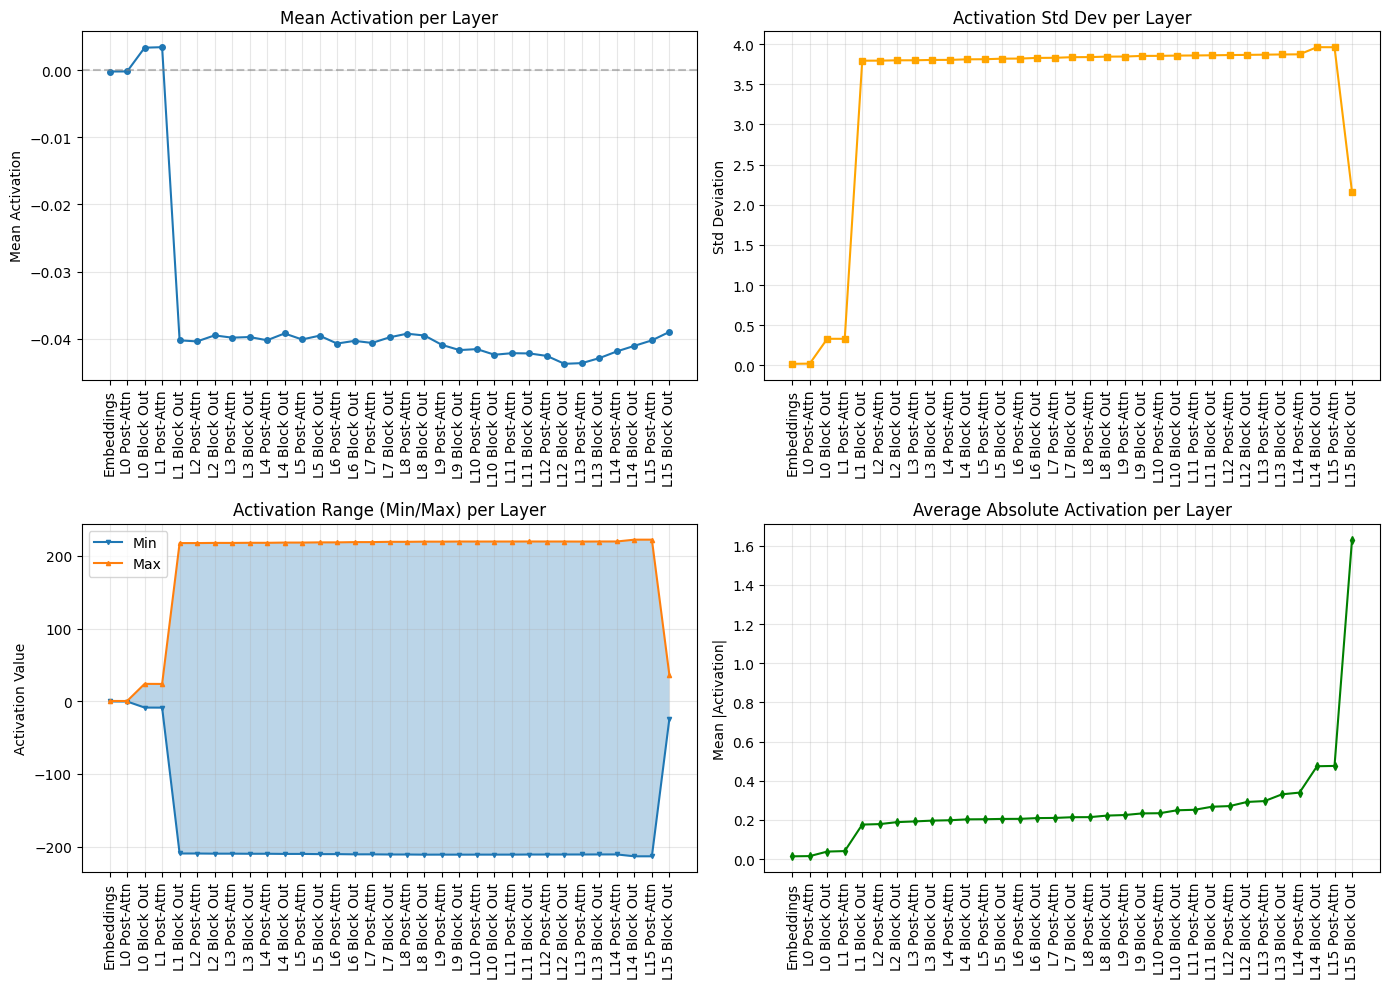

In [18]:
# Compute statistics per layer
stats = {
    'mean': hidden_states.mean(axis=(1, 2)),
    'std': hidden_states.std(axis=(1, 2)),
    'min': hidden_states.min(axis=(1, 2)),
    'max': hidden_states.max(axis=(1, 2)),
    'abs_mean': np.abs(hidden_states).mean(axis=(1, 2)),
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean activation
axes[0, 0].plot(stats['mean'], marker='o', markersize=4, label='Mean')
axes[0, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].set_xticks(range(len(layer_names)))
axes[0, 0].set_xticklabels(layer_names, rotation=90)
axes[0, 0].set_ylabel('Mean Activation')
axes[0, 0].set_title('Mean Activation per Layer')
axes[0, 0].grid(True, alpha=0.3)

# Std activation
axes[0, 1].plot(stats['std'], marker='s', markersize=4, color='orange')
axes[0, 1].set_xticks(range(len(layer_names)))
axes[0, 1].set_xticklabels(layer_names, rotation=90)
axes[0, 1].set_ylabel('Std Deviation')
axes[0, 1].set_title('Activation Std Dev per Layer')
axes[0, 1].grid(True, alpha=0.3)

# Min/Max range
axes[1, 0].fill_between(range(len(layer_names)), stats['min'], stats['max'], alpha=0.3)
axes[1, 0].plot(stats['min'], marker='v', markersize=3, label='Min')
axes[1, 0].plot(stats['max'], marker='^', markersize=3, label='Max')
axes[1, 0].set_xticks(range(len(layer_names)))
axes[1, 0].set_xticklabels(layer_names, rotation=90)
axes[1, 0].set_ylabel('Activation Value')
axes[1, 0].set_title('Activation Range (Min/Max) per Layer')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Absolute mean
axes[1, 1].plot(stats['abs_mean'], marker='d', markersize=4, color='green')
axes[1, 1].set_xticks(range(len(layer_names)))
axes[1, 1].set_xticklabels(layer_names, rotation=90)
axes[1, 1].set_ylabel('Mean |Activation|')
axes[1, 1].set_title('Average Absolute Activation per Layer')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Residual Stream vs Attention/MLP Output Magnitudes

In [19]:
# Compute attention and MLP outputs by taking differences
# For block i:
#   Attention output = hidden_states[2*i + 1] - hidden_states[2*i]
#   MLP output = hidden_states[2*i + 2] - hidden_states[2*i + 1]

attention_outputs = []
mlp_outputs = []
residual_at_block_input = []

for i in range(num_blocks):
    prev_idx = 2 * i
    post_attn_idx = 2 * i + 1
    block_out_idx = 2 * i + 2
    
    attention_outputs.append(hidden_states[post_attn_idx] - hidden_states[prev_idx])
    mlp_outputs.append(hidden_states[block_out_idx] - hidden_states[post_attn_idx])
    residual_at_block_input.append(hidden_states[prev_idx])

attention_outputs = np.array(attention_outputs)
mlp_outputs = np.array(mlp_outputs)
residual_at_block_input = np.array(residual_at_block_input)

# Compute L2 norms
residual_l2 = np.linalg.norm(residual_at_block_input, axis=-1)
attn_out_l2 = np.linalg.norm(attention_outputs, axis=-1)
mlp_out_l2 = np.linalg.norm(mlp_outputs, axis=-1)

# Average over tokens
avg_residual_l2 = residual_l2.mean(axis=1)
avg_attn_l2 = attn_out_l2.mean(axis=1)
avg_mlp_l2 = mlp_out_l2.mean(axis=1)

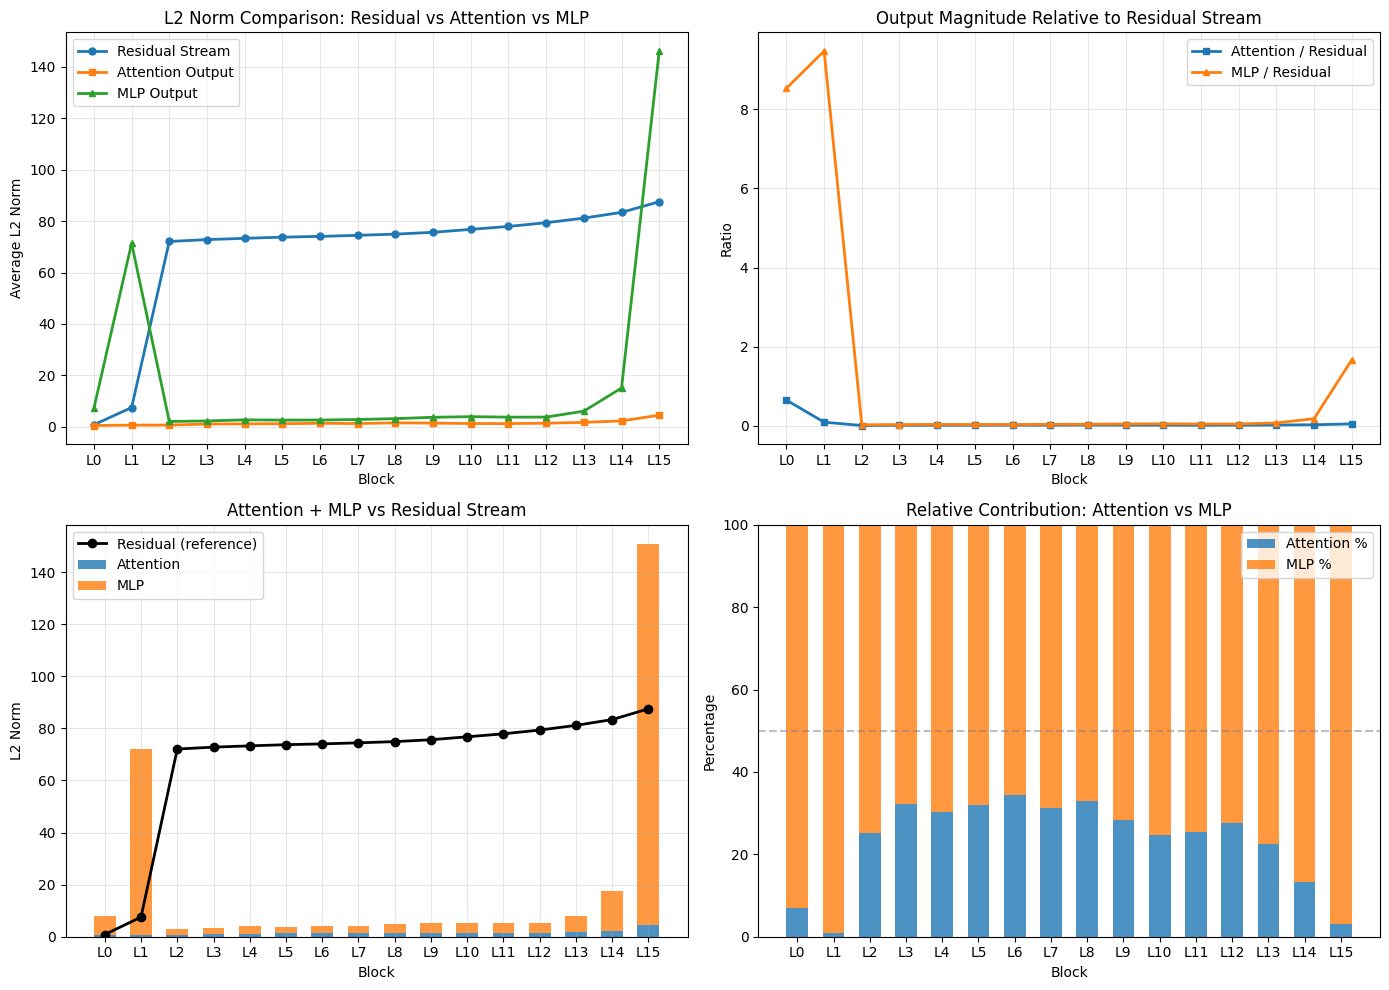

In [20]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Line plot comparison
ax = axes[0, 0]
ax.plot(avg_residual_l2, marker='o', markersize=5, label='Residual Stream', linewidth=2)
ax.plot(avg_attn_l2, marker='s', markersize=5, label='Attention Output', linewidth=2)
ax.plot(avg_mlp_l2, marker='^', markersize=5, label='MLP Output', linewidth=2)
ax.set_xticks(range(num_blocks))
ax.set_xticklabels(block_labels)
ax.set_xlabel('Block')
ax.set_ylabel('Average L2 Norm')
ax.set_title('L2 Norm Comparison: Residual vs Attention vs MLP')
ax.legend()
ax.grid(True, alpha=0.3)

# Ratio: Attention/Residual and MLP/Residual
ax = axes[0, 1]
attn_ratio = avg_attn_l2 / avg_residual_l2
mlp_ratio = avg_mlp_l2 / avg_residual_l2
ax.plot(attn_ratio, marker='s', markersize=5, label='Attention / Residual', linewidth=2)
ax.plot(mlp_ratio, marker='^', markersize=5, label='MLP / Residual', linewidth=2)
ax.set_xticks(range(num_blocks))
ax.set_xticklabels(block_labels)
ax.set_xlabel('Block')
ax.set_ylabel('Ratio')
ax.set_title('Output Magnitude Relative to Residual Stream')
ax.legend()
ax.grid(True, alpha=0.3)

# Stacked bar
ax = axes[1, 0]
x = np.arange(num_blocks)
width = 0.6
ax.bar(x, avg_attn_l2, width, label='Attention', alpha=0.8)
ax.bar(x, avg_mlp_l2, width, bottom=avg_attn_l2, label='MLP', alpha=0.8)
ax.plot(x, avg_residual_l2, 'ko-', markersize=6, label='Residual (reference)', linewidth=2)
ax.set_xticks(x)
ax.set_xticklabels(block_labels)
ax.set_xlabel('Block')
ax.set_ylabel('L2 Norm')
ax.set_title('Attention + MLP vs Residual Stream')
ax.legend()
ax.grid(True, alpha=0.3)

# Percentage contribution
ax = axes[1, 1]
total_contribution = avg_attn_l2 + avg_mlp_l2
attn_pct = (avg_attn_l2 / total_contribution) * 100
mlp_pct = (avg_mlp_l2 / total_contribution) * 100
ax.bar(x, attn_pct, width, label='Attention %', alpha=0.8)
ax.bar(x, mlp_pct, width, bottom=attn_pct, label='MLP %', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(block_labels)
ax.set_xlabel('Block')
ax.set_ylabel('Percentage')
ax.set_title('Relative Contribution: Attention vs MLP')
ax.legend()
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

## 4. Cosine Similarity: Residual vs Attention/MLP Outputs

In [21]:
# Compute cosine similarity between residual stream and attention/MLP outputs
cosine_residual_attn = np.zeros((num_blocks, seq_len))
cosine_residual_mlp = np.zeros((num_blocks, seq_len))

for block_idx in range(num_blocks):
    for token_idx in range(seq_len):
        residual_vec = residual_at_block_input[block_idx, token_idx]
        attn_vec = attention_outputs[block_idx, token_idx]
        mlp_vec = mlp_outputs[block_idx, token_idx]
        
        cosine_residual_attn[block_idx, token_idx] = cosine_similarity(residual_vec, attn_vec)
        cosine_residual_mlp[block_idx, token_idx] = cosine_similarity(residual_vec, mlp_vec)

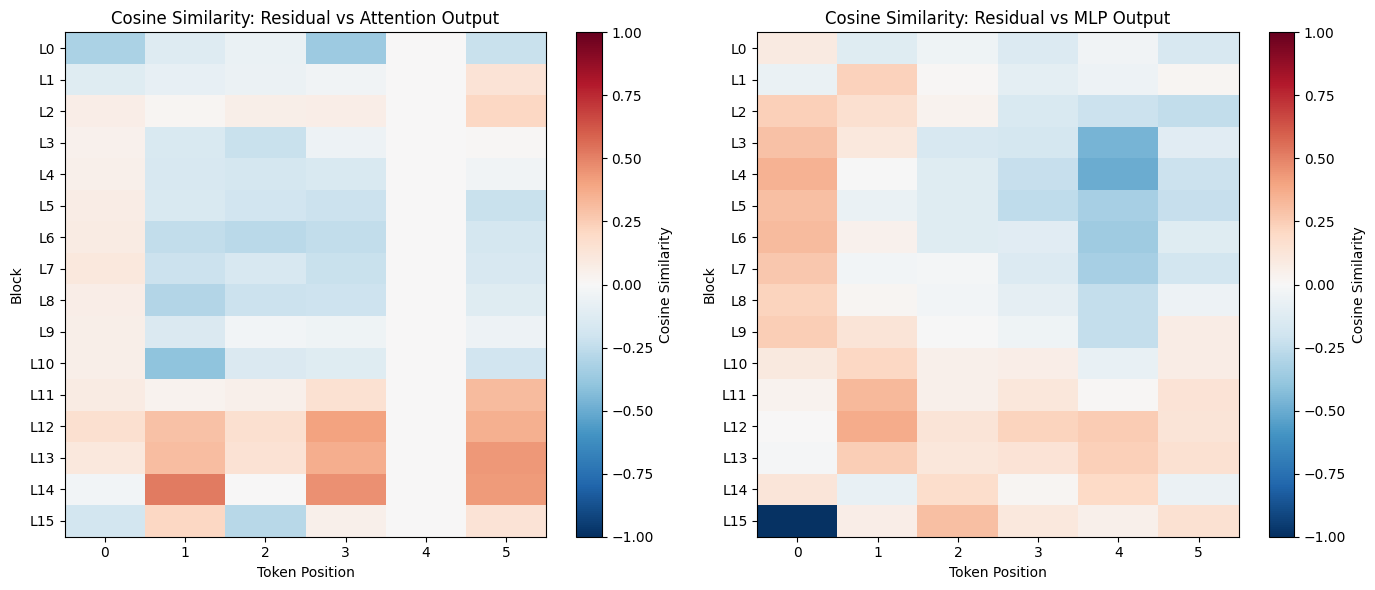

In [22]:
# Heatmaps of cosine similarity
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im0 = axes[0].imshow(cosine_residual_attn, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
axes[0].set_xlabel('Token Position')
axes[0].set_ylabel('Block')
axes[0].set_yticks(range(num_blocks))
axes[0].set_yticklabels(block_labels)
axes[0].set_title('Cosine Similarity: Residual vs Attention Output')
plt.colorbar(im0, ax=axes[0], label='Cosine Similarity')

im1 = axes[1].imshow(cosine_residual_mlp, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
axes[1].set_xlabel('Token Position')
axes[1].set_ylabel('Block')
axes[1].set_yticks(range(num_blocks))
axes[1].set_yticklabels(block_labels)
axes[1].set_title('Cosine Similarity: Residual vs MLP Output')
plt.colorbar(im1, ax=axes[1], label='Cosine Similarity')

plt.tight_layout()
plt.show()